# Pipeline Debug Mode (experimental)

## Overview

Debug mode is currently an experimental feature.

When you use DALI pipeline, you have to define the graph of operations ahead of time. In each iteration, the graph of operators is executed in the backend - and the user does not have access to the intermediate state, only to the pipeline outputs. This allows for better performance, but makes it harder to experiment and debug the pipeline. Debug mode allows you to access data as it's being processed in the graph. In standard DALI mode operators outputs are symbolic ([DataNode](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/pipeline.html#datanode)). In debug mode those become `DataNodeDebug` that contain the underlying data.

## Defining debug pipeline

Since debug mode is still in development and its functionalities might change it is accessible from the experimental version of `pipeline_def` which works the same as the standard version but allows you to debug. To use debug mode:

1. Change the standard version of `nvidia.dali.pipeline_def` to its experimental equivalent `nvidia.dali.pipeline.experimental.pipeline_def`

2. Define pipeline with parameter `debug=True`

Let's take a simple pipeline that reads images and rotates them and try out the debug mode on it.

In [1]:
import nvidia.dali.fn as fn
from nvidia.dali.pipeline.experimental import pipeline_def

image_dir = "../data/images"
max_batch_size = 8

@pipeline_def(batch_size=max_batch_size, num_threads=1, device_id=0, debug=True)
def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True, initial_fill=21)
    images = fn.decoders.image(jpegs, device='cpu')
    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)

    return rotated_images, labels

The basic use of debug mode is to print objects returned by operators. It gives you much of the information you might want to check. 

In [2]:
@pipeline_def(batch_size=max_batch_size, num_threads=1, device_id=0)
def simple_pipeline_with_print():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device='cpu')

    print(images)

    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)

    return rotated_images, labels


pipe = simple_pipeline_with_print(debug=True)
pipe.build()
pipe_out = pipe.run()

DataNodeDebug(
    name="__Image_2",
    data=TensorListCPU(
             [[[[231 234 239]
               [231 234 239]
               ...
               [231 238 246]
               [231 238 246]]

              [[231 234 239]
               [231 234 239]
               ...
               [231 238 246]
               [231 238 246]]

              ...

              [[246 247 251]
               [246 247 251]
               ...
               [247 248 252]
               [247 248 252]]

              [[245 246 250]
               [245 246 250]
               ...
               [248 249 253]
               [248 249 253]]]


             [[[ 26  28  25]
               [ 26  28  25]
               ...
               [ 34  39  33]
               [ 34  39  33]]

              [[ 26  28  25]
               [ 26  28  25]
               ...
               [ 34  39  33]
               [ 34  39  33]]

              ...

              [[ 35  46  30]
               [ 36  47  31]
               ...

Using it this way allows you to easily swap between standard and debug mode.

In [3]:
pipe_standard = simple_pipeline_with_print()
pipe_standard.build()
pipe_out = pipe_standard.run()

DataNode(name="__Image_6", device="cpu")


In debug mode each time you call `run` the code of your pipeline is executed (that way you can access the state of your pipeline in every iteration) as opposed to the standard mode where the code defining your pipeline is executed only once when you call `build`.

Notice how we get different prints every time we call `run`.

In [4]:
@pipeline_def(batch_size=max_batch_size, num_threads=1, device_id=0)
def simple_pipeline_with_print():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device='cpu')

    print(jpegs)

    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)

    return rotated_images, labels


pipe = simple_pipeline_with_print(debug=True)
pipe.build()
for _ in range(5):
    pipe.run()

DataNodeDebug(
    name="__File_8[0]",
    data=TensorListCPU(
             [[255 216 ... 255 217]
             [255 216 ... 255 217]
             ...
             [255 216 ... 255 217]
             [255 216 ... 255 217]],
             dtype=DALIDataType.UINT8,
             num_samples=8,
             shape=[(35646,), 
                    (26287,), 
                    (25958,), 
                    (91537,), 
                    (41063,), 
                    (33781,), 
                    (50295,), 
                    (23382,)]))
DataNodeDebug(
    name="__File_8[0]",
    data=TensorListCPU(
             [[255 216 ... 255 217]
             [255 216 ... 255 217]
             ...
             [255 216 ... 255 217]
             [255 216 ... 255 217]],
             dtype=DALIDataType.UINT8,
             num_samples=8,
             shape=[(35941,), 
                    (29762,), 
                    (24253,), 
                    (39469,), 
                    (23894,), 
                

While in standard mode the print is executed only once (when calling `build`) and `run` schedules execution of already defined graph in the backend.

In [5]:
pipe = simple_pipeline_with_print(debug=False)
pipe.build()
for _ in range(5):
    pipe.run()

DataNode(name="__File_13[0]", device="cpu")


## Additional features

Debug mode provides some additional features for data manipulation.

For example we can visualize the data that is produced as intermediate step in the pipeline.

In [6]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (max_batch_size + 1) // (columns)
    plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

### Data access

By calling `.get()` on a `DataNodeDebug` returned by an operator, you can access the underlying `TensorList` directly, which is not possible with a standard `DataNode`.

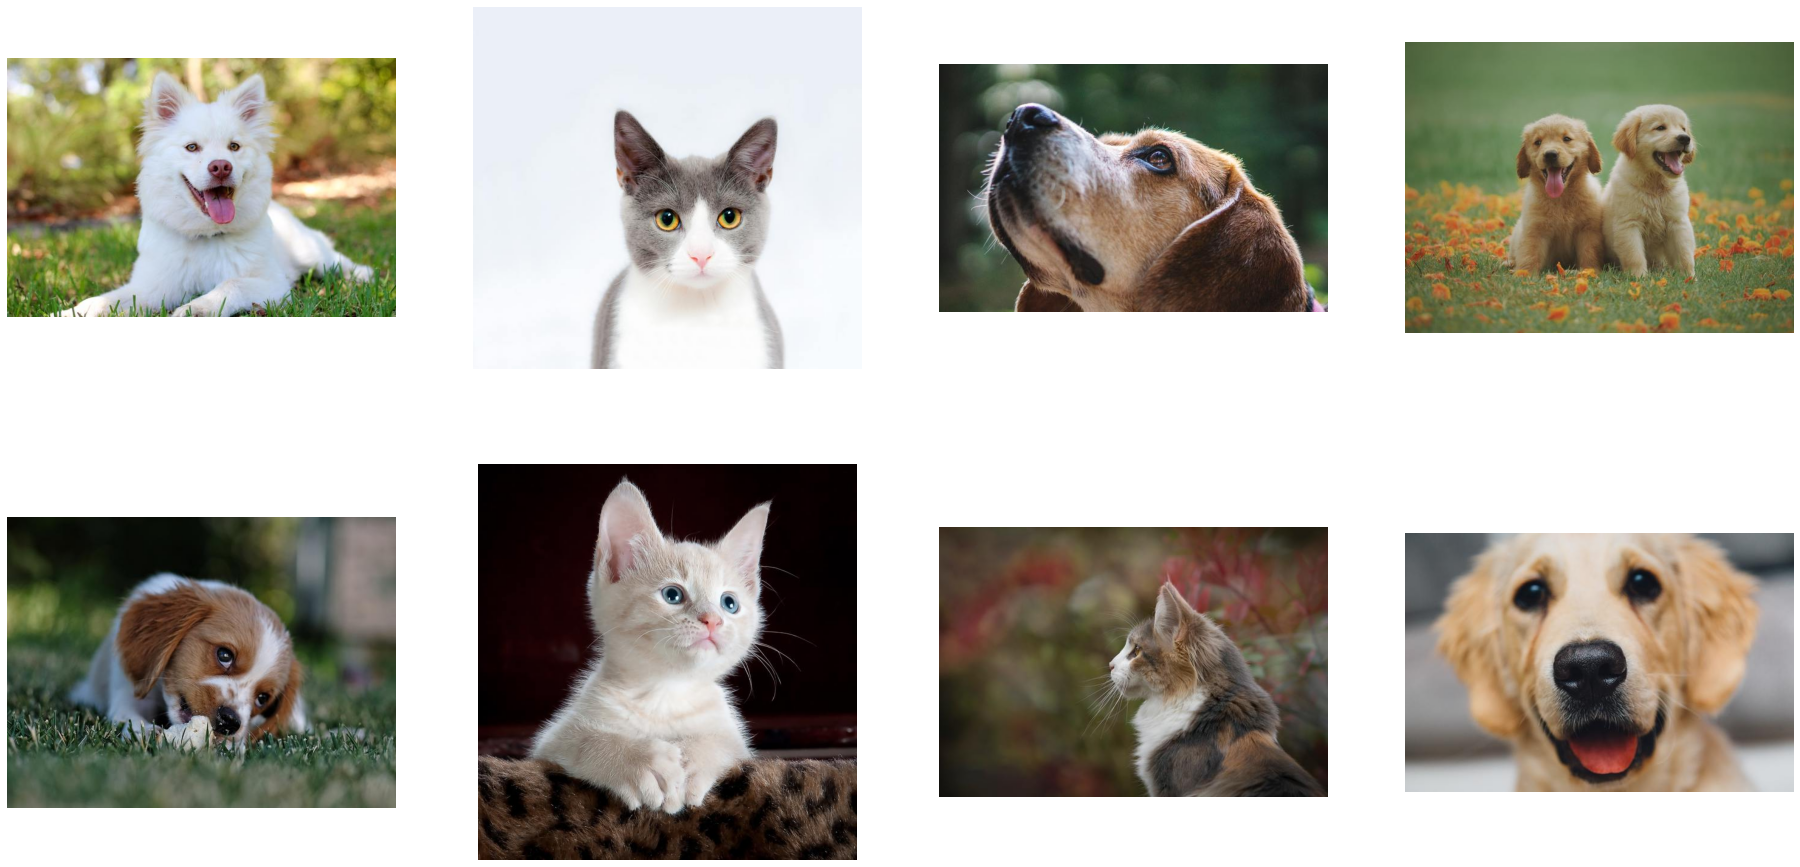

In [7]:
@pipeline_def(batch_size=8, num_threads=1, device_id=0, debug=True)
def simple_pipeline_with_show():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device='cpu')
    
    show_images(images.get())

    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)

    return rotated_images, labels


pipe = simple_pipeline_with_show(debug=True)
pipe.build()
pipe_out = pipe.run()

You can check shape of the data.

In [8]:
iter = 0

@pipeline_def(batch_size=8, num_threads=1, device_id=0, debug=True)
def simple_pipeline_with_shape():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device='cpu')

    print(f'Iteration {iter}, shapes={images.shape()}')

    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)

    return rotated_images, labels


pipe = simple_pipeline_with_shape(debug=True)
pipe.build()
for _ in range(5):
    pipe_out = pipe.run()
    iter += 1

Iteration 0, shapes=[(427, 640, 3), (480, 640, 3), (669, 640, 3), (427, 640, 3), (427, 640, 3), (425, 640, 3), (480, 640, 3), (480, 640, 3)]
Iteration 1, shapes=[(427, 640, 3), (427, 640, 3), (427, 640, 3), (425, 640, 3), (427, 640, 3), (446, 640, 3), (597, 640, 3), (480, 640, 3)]
Iteration 2, shapes=[(485, 640, 3), (425, 640, 3), (409, 640, 3), (427, 640, 3), (427, 640, 3), (446, 640, 3), (427, 640, 3), (427, 640, 3)]
Iteration 3, shapes=[(480, 640, 3), (597, 640, 3), (485, 640, 3), (427, 640, 3), (425, 640, 3), (427, 640, 3), (427, 640, 3), (427, 640, 3)]
Iteration 4, shapes=[(480, 640, 3), (425, 640, 3), (427, 640, 3), (427, 640, 3), (669, 640, 3), (480, 640, 3), (427, 640, 3), (425, 640, 3)]


### Data modification

You can modify the data (e.g. by casting it to a NumPy ndarray or a PyTorch tensor) and then pass it directly to the operator. Operators in debug mode accept same sources as [External Source Operator](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/supported_ops.html#nvidia.dali.fn.external_source).

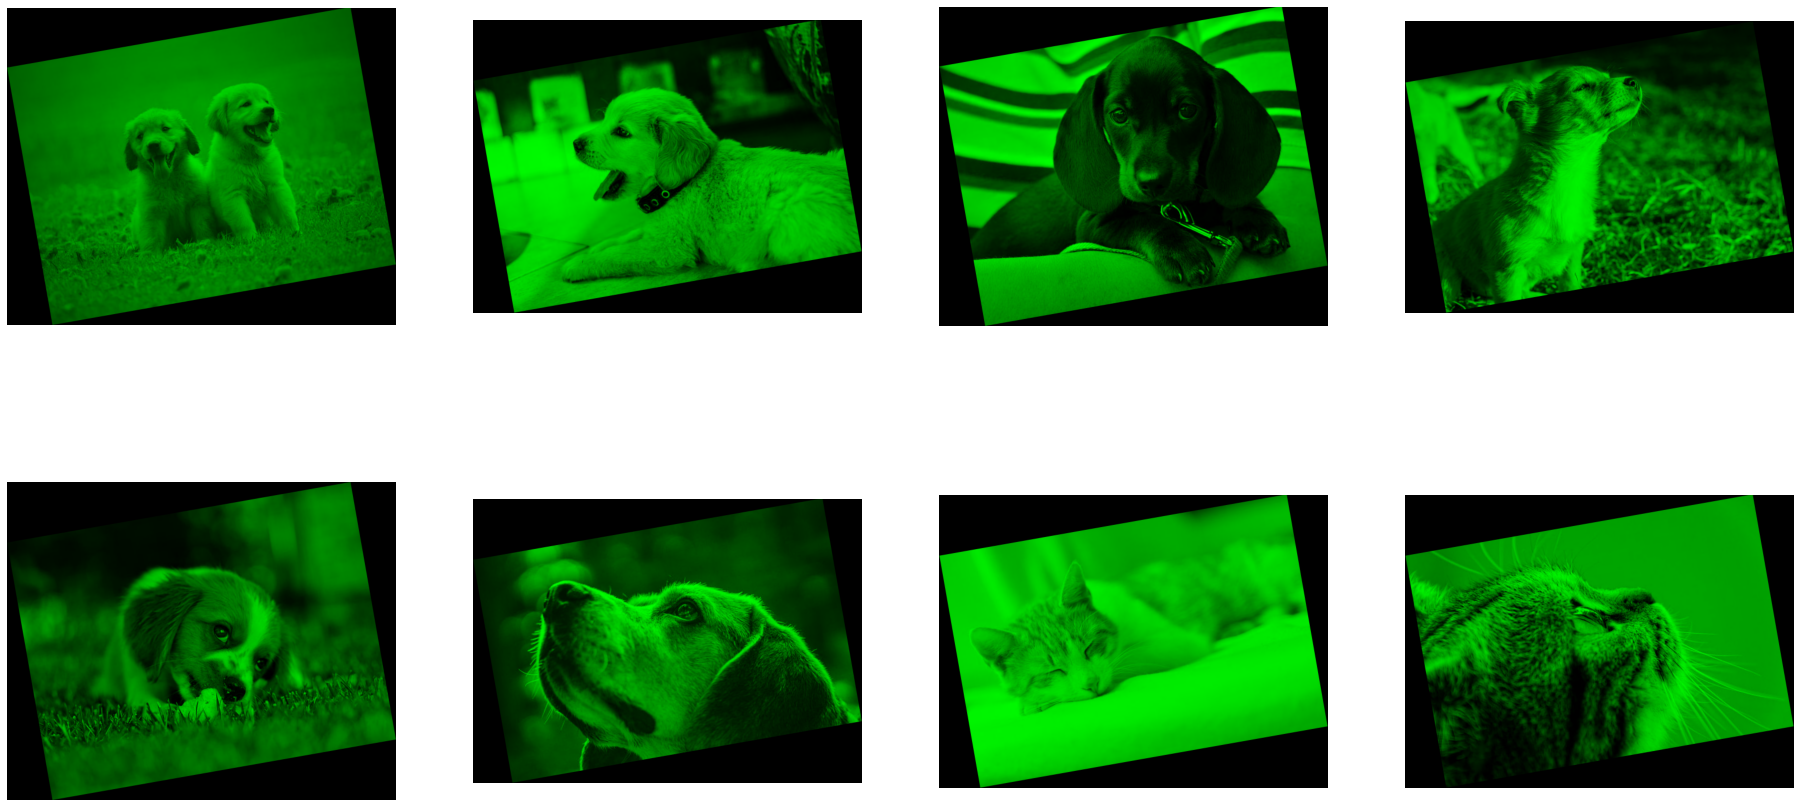

In [9]:
import numpy as np

@pipeline_def(batch_size=8, num_threads=1, device_id=0, debug=True)
def simple_pipeline_with_modification():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device='cpu')

    images = [np.array(tensor) for tensor in images.get()]
    for image in images:
        image[:, :, [0, 2]] = 0

    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)
    show_images(rotated_images.get())
    
    return rotated_images, labels

pipe = simple_pipeline_with_modification(debug=True)
pipe.build()
pipe_out = pipe.run()

# Notice

* Debug mode is not meant to be fast, in this mode performance of your pipeline will be far worse, use it only for experimenting.
* Seed generation in debug mode works differently than in standard mode (it is deterministic but different). If you want to achieve the same results in debug mode as in standard mode initialize operators with the `seed` parameter.
* Direct calls to operators work only in a scope of the `pipeline_def` function, you cannot use them this way outside of `pipeline_def`.
* As debug mode is meant to imitate execution of standard mode as closely as possible you cannot change the order of operators.
For example, this is not allowed:

RuntimeError: Unexpected operator 'crop'. Debug mode does not support changing the order of operators executed within the pipeline.

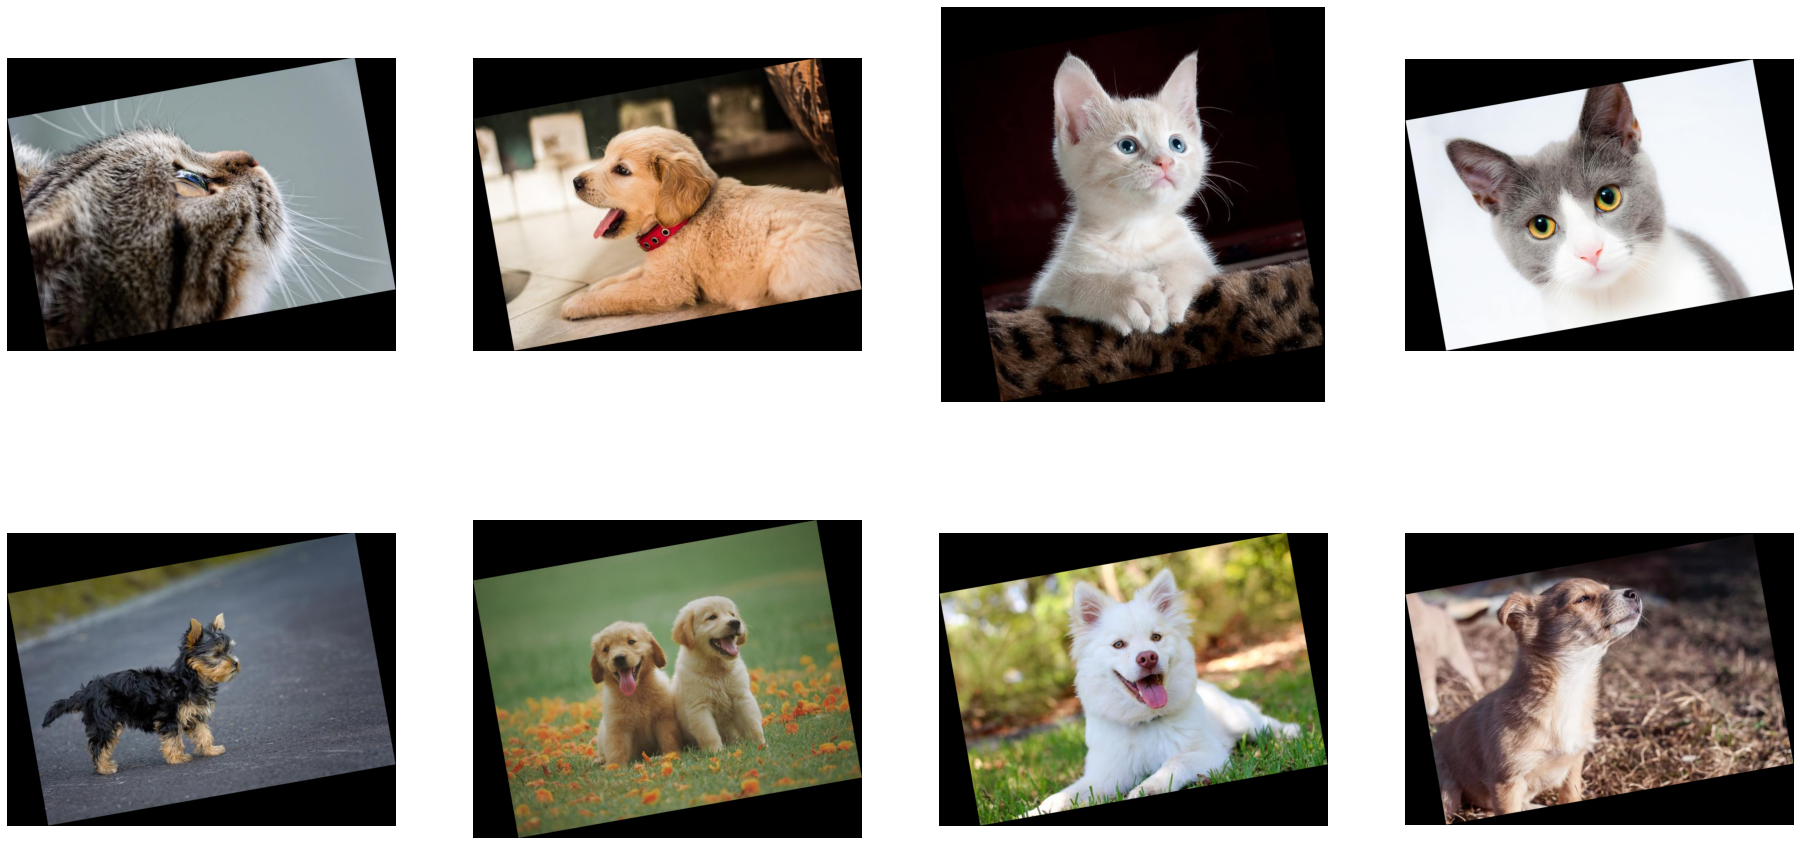

In [10]:
iter = 0

@pipeline_def(batch_size=8, num_threads=1, device_id=0, debug=True)
def corrupted_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device='cpu')
    
    if iter == 1:
        images = fn.crop(images, crop=[256, 256])

    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)
    show_images(rotated_images.get())
    
    return rotated_images, labels

pipe = corrupted_pipeline(debug=True)
pipe.build()
for _ in range(2):
    pipe_out = pipe.run()
    iter += 1